### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py
%run german_dataprep.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

The data objects are now saved and given a set of generic names ease of use.

In [2]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()

In [3]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.7571
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 1000, 'max_depth': 16}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.3626
Confusion matrix, without normalization
[[ 39  61]
 [ 14 186]]
Normalized confusion matrix
[[0.39 0.61]
 [0.07 0.93]]


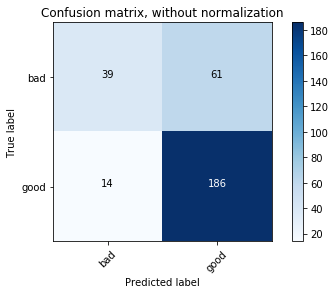

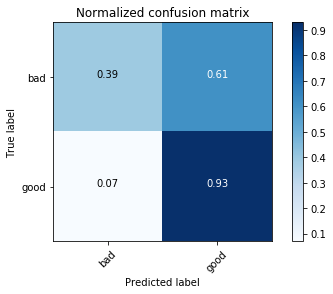

In [4]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')


In [32]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [36]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

batch = X_test
labels = y_test

if True:
    
    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()
        

##### Load previously saved results

In [38]:
tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

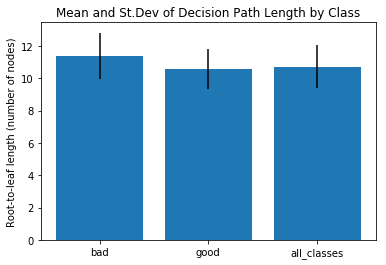

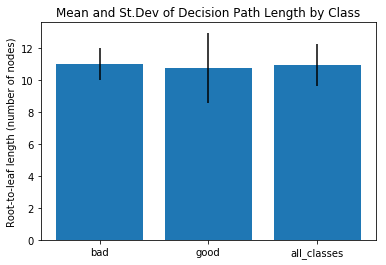

In [39]:
# comparing mean path lengths
plot_mean_path_lengths(tt_correct_stats, class_labels=class_names)
plot_mean_path_lengths(tt_incorrect_stats, class_labels=class_names)

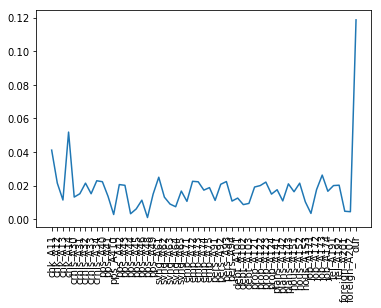

In [40]:
plt.plot(rf.feature_importances_)
plt.xticks(range(len(onehot_features)), onehot_features, rotation='vertical')
plt.show()

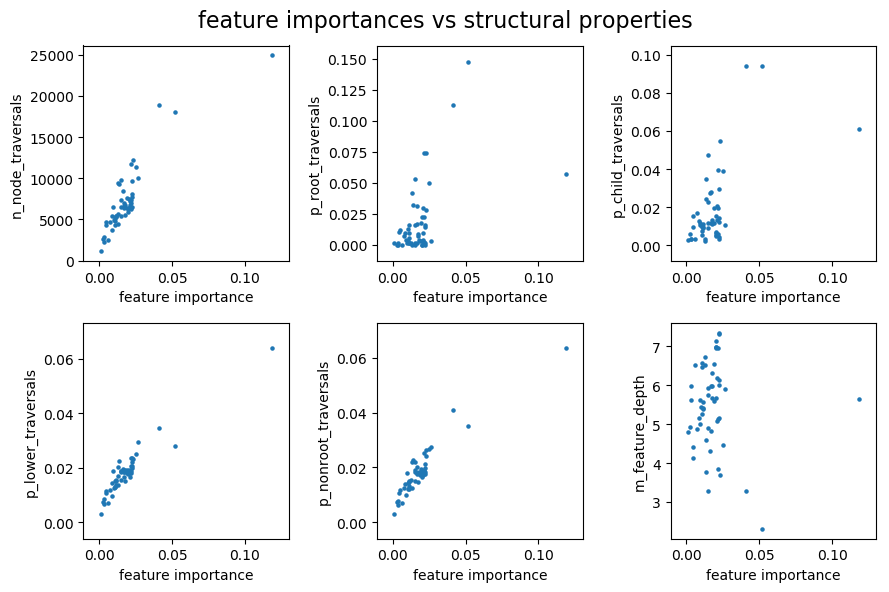

In [41]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 0)

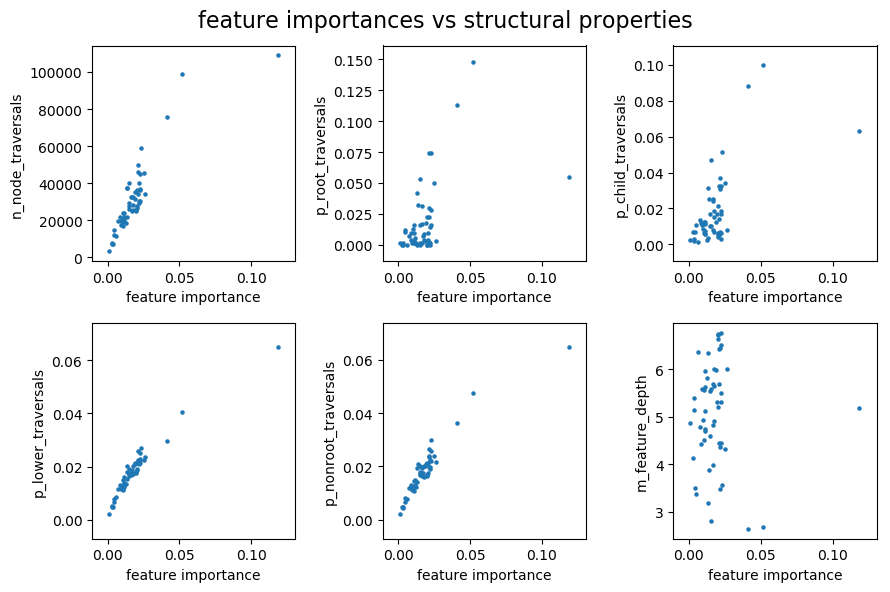

In [42]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 1)

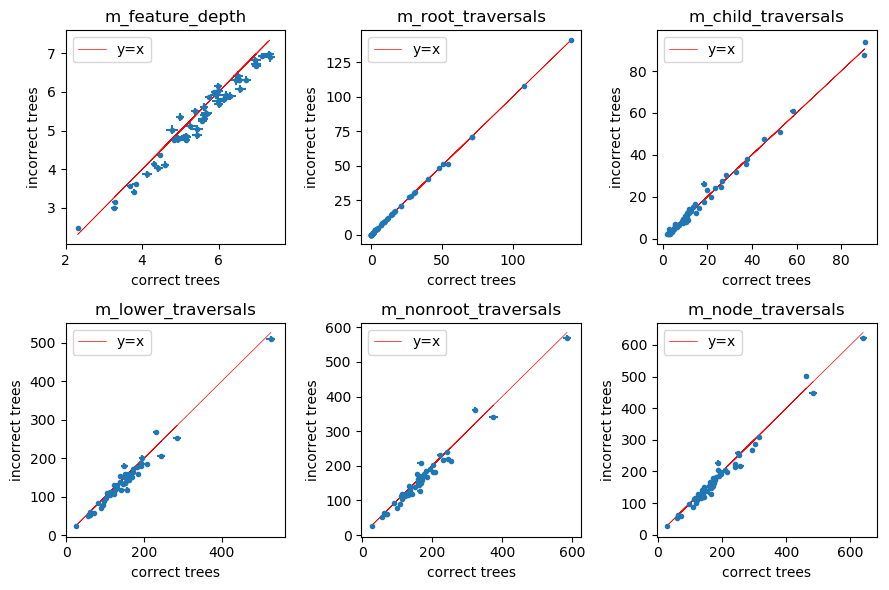

In [43]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 0)

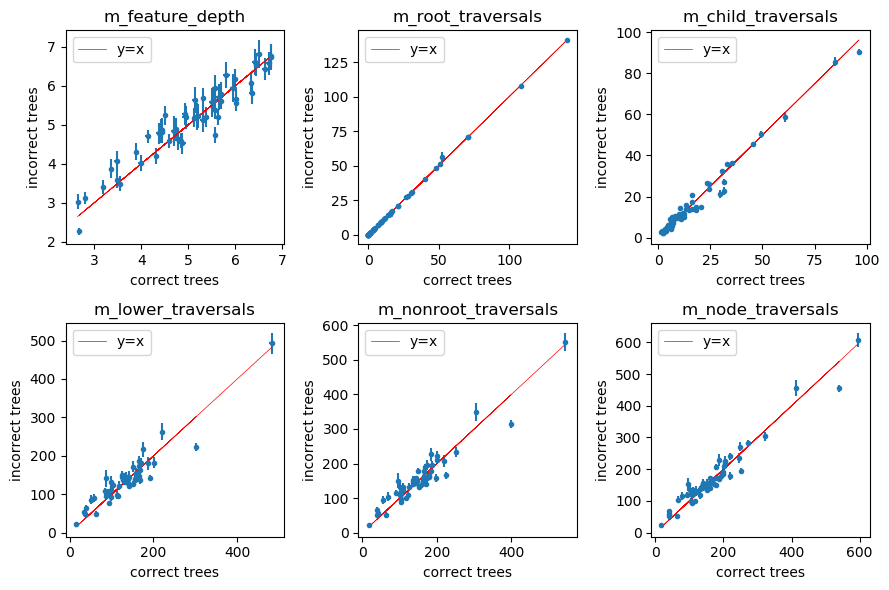

In [44]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 1)

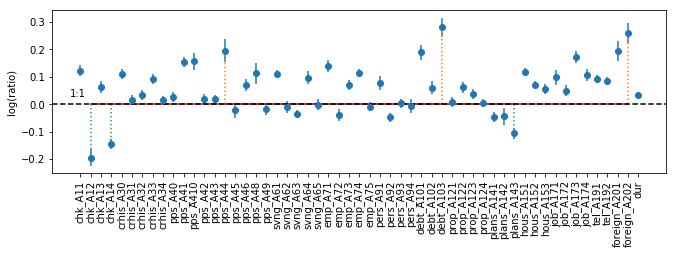

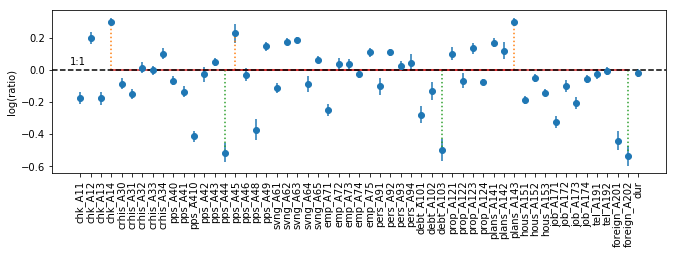

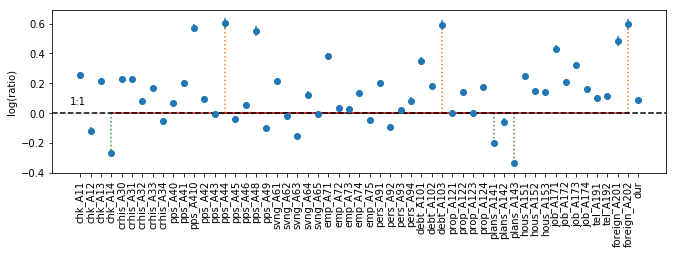

In [45]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals']
                            , num_err = tt_correct_stats[1]['se_lower_traversals']
                            , denom = tt_incorrect_stats[1]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[1]['se_lower_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_correct_stats[1]['m_lower_traversals']
                            , denom_err = tt_correct_stats[1]['se_lower_traversals']
                            , labels = onehot_features
)

In [4]:
first_n = 5

batch = X_test[0:first_n]
labels = y_test[0:first_n]

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

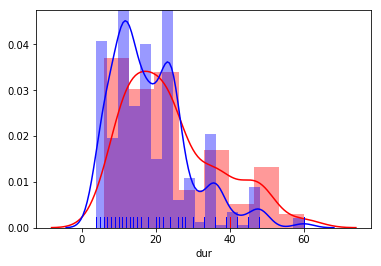

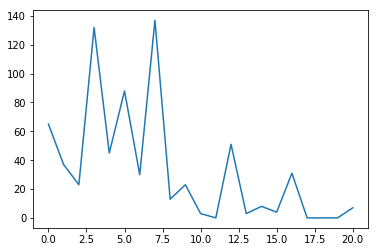

498    18
243    12
314     4
202    27
300     6
682    15
230    36
306    30
166    18
620    21
724    27
263    12
326    12
232    12
150     6
469    24
132    15
9      30
254     9
952    24
379     6
581    12
82     18
64     24
767    10
369    18
528    36
449    15
119    12
773    24
       ..
208    24
608    18
420    15
253    24
846    18
339    10
409    12
111    15
224    15
942    24
544    12
73     42
47      6
638    12
113    36
96     12
737    18
214    36
569    48
123    10
106    18
595     6
17     30
742    21
98     36
988    24
322    24
382    22
365    12
510    12
Name: dur, Length: 700, dtype: int64

In [33]:
X_train
import seaborn as sns
y_train.values == 0
p1=sns.distplot(X_train.dur.loc[y_train.values == 0], hist=True, kde=True, rug=True, color="r")
p1=sns.distplot(X_train.dur.loc[y_train.values == 1], hist=True, kde=True, rug=True, color="b")
#p1=sns.distplot(downers, hist=True, kde=True, rug=True, color="b")
plt.show()


plt.plot(np.histogram(X_train.dur, bins='fd')[0])
plt.show()

#np.histogram(X_train.dur, bins='fd')[1]
pd.rolling_mean(np.histogram(X_train.dur, bins='fd')[1], 2)

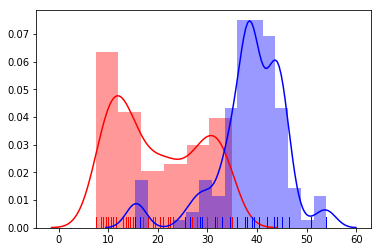

In [250]:
lowers = [item[2] for nodes in paths for item in nodes if item[0] == feature and item[1] == False]
# upper bound, less than
uppers = [item[2] for nodes in paths for item in nodes if item[0] == feature and item[1] == True]

upper_bins = np.histogram(uppers, bins=bins)[1]
lower_bins = np.histogram(lowers, bins=bins)[1]

# upper_bin_midpoints = pd.Series(upper_bins).rolling(window=2, center=False).mean().values[1:]
upper_bin_means = (np.histogram(uppers, upper_bins, weights=uppers)[0] /
                    np.histogram(uppers, upper_bins)[0]).round(2)

# lower_bin_midpoints = pd.Series(lower_bins).rolling(window=2, center=False).mean().values[1:]
lower_bin_means = (np.histogram(lowers, lower_bins, weights=lowers)[0] /
                    np.histogram(lowers, lower_bins)[0]).round(2)

# discretize functions from histogram means
upper_discretize = lambda x: upper_bin_means[np.max([np.min([np.digitize(x, upper_bins), len(upper_bin_means)]), 1]) - 1]
lower_discretize = lambda x: lower_bin_means[np.max([np.min([np.digitize(x, lower_bins, right= True), len(upper_bin_means)]), 1]) - 1]

p1=sns.distplot(lowers, hist=True, kde=True, rug=True, color="r")
p1=sns.distplot(uppers, hist=True, kde=True, rug=True, color="b")
#p1=sns.distplot(downers, hist=True, kde=True, rug=True, color="b")
plt.show()




In [47]:
pd.Series(np.histogram(X_train.dur, bins='doane')[1]).rolling(window=2, center=False).mean().values[1:]

array([ 5.86666667,  9.6       , 13.33333333, 17.06666667, 20.8       ,
       24.53333333, 28.26666667, 32.        , 35.73333333, 39.46666667,
       43.2       , 46.93333333, 50.66666667, 54.4       , 58.13333333])

In [216]:
# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='majority'), vars_dict, 'fd'),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='minority'), vars_dict, 'fd'),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)
sorted_fp

C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:923: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(2)
C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:919: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(2)


No frequent patterns longer than 2 items. Stopping early.
No frequent patterns longer than 2 items. Stopping early.


[((('svng_A61', False, 0.5),), 160, 5.075173815233827),
 ((('crhis_A34', True, 0.5),), 127, 4.844187086458591),
 ((('crhis_A31', True, 0.5),), 124, 4.820281565605037),
 ((('amt', False, 3930.48),), 112, 4.718498871295094),
 ((('res', False, 1.5),), 102, 4.624972813284271),
 ((('emp_A72', True, 0.5),), 99, 4.59511985013459),
 ((('hous_A151', True, 0.5),), 97, 4.574710978503383),
 ((('crhis_A30', True, 0.5),), 94, 4.543294782270004),
 ((('job_A174', True, 0.5),), 93, 4.532599493153256),
 ((('job_A172', True, 0.5),), 90, 4.499809670330265),
 ((('pers_A93', False, 0.5),), 87, 4.465908118654584),
 ((('plans_A143', True, 0.5),), 84, 4.430816798843313),
 ((('pps_A46', False, 0.5),), 84, 4.430816798843313),
 ((('dur', False, 10.27),), 83, 4.418840607796598),
 ((('pps_A40', True, 0.5),), 82, 4.406719247264253),
 ((('prop_A121', True, 0.5),), 81, 4.394449154672439),
 ((('debt_A103', True, 0.5),), 80, 4.382026634673881),
 ((('crhis_A32', True, 0.5),), 79, 4.3694478524670215),
 ((('crhis_A33', Fal

In [7]:
def tree_path(tree, instances, labels = None, feature_encoding = None, feature_names = None):

    n_instances = instances.shape[0]
    instances, n_features, addendum = enc_features(instances, feature_encoding)

    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    tree_pred = tree.predict(instances)
    tree_pred_proba = tree.predict_proba(instances)

    if labels is None:
        tree_correct = [None] * n_instances
    else:
        tree_correct = tree_pred == labels.values

    path = tree.decision_path(instances).indices
    path_deque = deque(path)
    ic = -1 # instance_count
    instance_paths = [{}] * n_instances
    while len(path_deque) > 0:
        p = path_deque.popleft()
        if feature[p] < 0: # leaf node
            continue
        feature_value = instances.todense()[ic, [feature[p]]].item(0)
        leq_threshold = feature_value <= threshold[p]
        if feature_names is None:
            feature_name = None
        else:
            feature_name = feature_names[feature[p]]
        if p == 0: # root node
            ic += 1
            if labels is None:
                true_class = None
            else:
                true_class = labels.values[ic]
            instance_paths[ic] = { 'pred_class' : tree_pred[ic].astype(np.int64)
                                    , 'pred_proba' : tree_pred_proba[ic].tolist()
                                    , 'true_class' : true_class
                                    , 'tree_correct' : tree_correct[ic]
                                    , 'path' : {'feature_idx' : [feature[p]]
                                                            , 'feature_name' : [feature_name]
                                                            , 'feature_value' : [feature_value]
                                                            , 'threshold' : [threshold[p]]
                                                            , 'leq_threshold' : [leq_threshold]
                                                }
                                    }
        else:
            instance_paths[ic]['path']['feature_idx'].append(feature[p])
            instance_paths[ic]['path']['feature_name'].append(feature_name)
            instance_paths[ic]['path']['feature_value'].append(feature_value)
            instance_paths[ic]['path']['threshold'].append(threshold[p])
            instance_paths[ic]['path']['leq_threshold'].append(leq_threshold)

    return(instance_paths)

tp = tree_path(tree = rf.estimators_[4]
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder)

In [9]:
paths = {}
sorted_fp = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')
    print('Instance ' + str(instance) + ':    True Class = ' + 
        str(labels[instance:instance+1].values[0]) + ' ' + 
          get_label(class_col, labels[instance:instance+1].values[0]) + 
        '    Majority voting trees = ' + str(len(paths[instance])))

Instance 0:    True Class = 0 bad    Majority voting trees = 704
Instance 1:    True Class = 0 bad    Majority voting trees = 522
Instance 2:    True Class = 1 good    Majority voting trees = 661
Instance 3:    True Class = 0 bad    Majority voting trees = 737
Instance 4:    True Class = 1 good    Majority voting trees = 720


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

In [217]:
instance = 3

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# Display instance row
germ_id = batch[instance:instance + 1].index[0]
german[germ_id:germ_id + 1]

Test instance id: 3
True class: 0
Pedicted Class Probabilities 
0 bad 0.6312
1 good 0.3688


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,chk,dur,crhis,pps,amt,svng,emp,rate,pers,debt,...,prop,age,plans,hous,creds,job,deps,tel,foreign,rating
585,A11,18,A32,A42,2039,A61,A73,1,A92,A101,...,A121,20,A141,A151,1,A173,1,A191,A201,bad


In [23]:
class rule_accumulator:

    def __init__(self, vars_dict, onehot_dict, rule_list):
        # TO DO: make scored_list (of rules) a class? Output of sort_fp function, which could be part of fp object?
        # TO DO: then check type on init
        self.onehot_dict = onehot_dict
        self.vars_list = deepcopy(vars_dict)
        self.rule_list = rule_list
        self.unapplied_rules = [i for i in range(len(self.rule_list))]
        for item in self.vars_list:
            if self.vars_list[item]['class_col']:
                continue
            else:
                if self.vars_list[item]['data_type'] == 'nominal':
                    n_labs = len(self.vars_list[item]['labels'])
                else:
                    n_labs = 1
                self.vars_list[item]['upper_bound'] = [math.inf] * n_labs
                self.vars_list[item]['lower_bound'] = [-math.inf] * n_labs
        self.rule = []

        self.total_points = sum([scrs[2] for scrs in self.rule_list])
        self.accumulated_points = 0

    def add_rule(self, p_total = 0.1):
        if self.accumulated_points + self.rule_list[0][2] > self.total_points * p_total:
            raise UserWarning('Adding another rule will exceed the maximum points. To carry on adding rules, increase p_total')
        else:
            # next_rule = self.scored_list.popleft()
            next_rule = self.rule_list[self.unapplied_rules[0]]
            for item in next_rule[0]:
                if item not in self.rule:
                    self.rule.append(item)
                    # update the master list how the rule has been used
                    position = self.vars_list[self.onehot_dict[item[0]]]['onehot_labels'].index(item[0])
                    #self.vars_list[self.onehot_dict[item[0]]]['onehot_labels'][position]
                    if item[1]: # leq_threshold True
                        self.vars_list[self.onehot_dict[item[0]]]['upper_bound'][position] = item[2]
                    else:
                        self.vars_list[self.onehot_dict[item[0]]]['lower_bound'][position] = item[2]

            # accumlate all the freq patts that are subsets of the current rules
            # remove the index from the unapplied rules list (including the current rule just added)
            to_remove = []
            for ur in self.unapplied_rules:
                # check if all items are already part of the rule (i.e. it's a subset)
                if all([item in self.rule for item in self.rule_list[ur][0]]):
                    self.accumulated_points += self.rule_list[ur][2]
                    # collect up the values to remove. don't want to edit the iterator in progress
                    to_remove.append(ur)
            for rmv in reversed(to_remove):
                self.unapplied_rules.remove(rmv)
            return(self.rule, self.accumulated_points)

    def prune_rule(self):
        # remove all other binary items if one Greater than is found.
        gt_items = {} # find all the items with the leq_threshold False
        for item in self.rule:
            if ~item[1] and self.vars_list[self.onehot_dict[item[0]]]['data_type'] == 'nominal': # item is greater than thresh and a nominal type
                gt_items[self.onehot_dict[item[0]]] = item[0] # capture the parent feature and the feature value

        gt_pruned_rule = []
        for item in self.rule:
            if self.onehot_dict[item[0]] not in gt_items.keys():
                gt_pruned_rule.append(item)
            elif ~item[1]:
                gt_pruned_rule.append(item)

        # if all but one of a feature set is False, swap them out for the remaining value
        # start by counting all the lt thresholds in each parent feature
        lt_items = defaultdict(lambda: 0)
        for item in gt_pruned_rule: # find all the items with the leq_threshold True
            if item[1] and self.vars_list[self.onehot_dict[item[0]]]['data_type'] == 'nominal': # item is greater than thresh and a nominal type
                lt_items[self.onehot_dict[item[0]]] += 1 # capture the parent feature and count each

        # checking if just one other feature value remains unused
        pruned_items = [item[0] for item in gt_pruned_rule]
        for lt in dict(lt_items).keys():
            n_categories = len([i for i in self.onehot_dict.values() if i == lt])
            if n_categories - dict(lt_items)[lt] == 1:
                # get the remaining value for this feature
                lt_labels = self.vars_list[lt]['onehot_labels']
                to_remove = [label for label in lt_labels if label in pruned_items]
                remaining_value = [label for label in lt_labels if label not in pruned_items]

                lt_pruned_rule = []
                pos = -1
                for rule in gt_pruned_rule:
                    pos += 1
                    if rule[0] not in to_remove:
                        lt_pruned_rule.append(rule)
                    else:
                        # set the position of the last term of the parent feature
                        insert_pos = pos
                        pos -= 1
                lt_pruned_rule.insert(insert_pos, (remaining_value[0], False, 0.5))
                # the main rule is updated for passing through the loop again
                gt_pruned_rule = lt_pruned_rule.copy()

        self.pruned_rule = gt_pruned_rule

        # find a rule with only binary True values
        self.tight_rule = [r for r in self.pruned_rule if ~r[1]]


# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='majority'),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='minority'),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)

ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

No frequent patterns longer than 2 items. Stopping early.
No frequent patterns longer than 2 items. Stopping early.


In [6]:
first_n = 20

batch = X_test[0:first_n]
labels = y_test[0:first_n]

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:919: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(2)
C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:923: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(2)


No frequent patterns longer than 2 items. Stopping early.
('amt', True, 2373.2) feature first added
('amt', True, 2373.2) feature appears already
('amt', True, 2373.2) feature values appears already
('dur', False, 10.26) feature first added
('age', True, 31.46) feature first added
('amt', True, 2373.2) feature appears already
('amt', True, 2373.2) feature values appears already


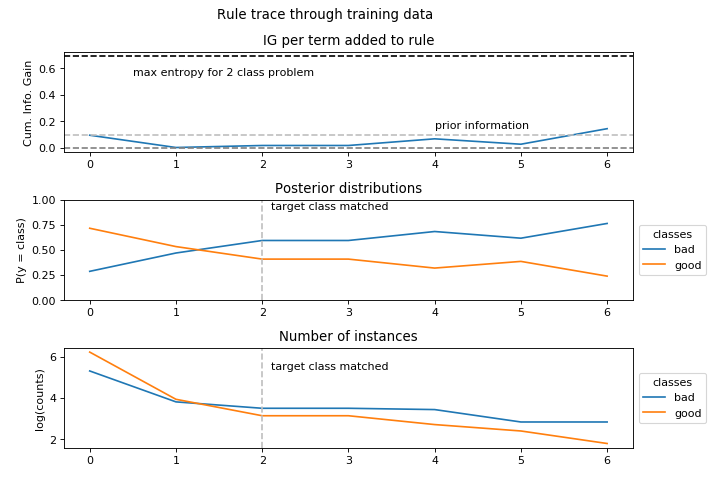

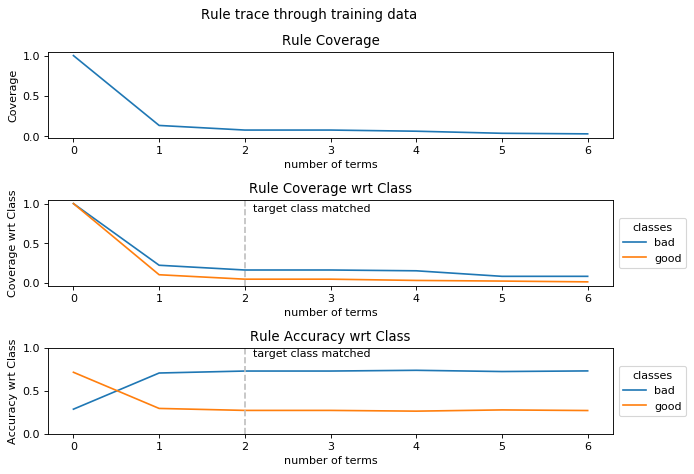

No frequent patterns longer than 2 items. Stopping early.
('dur', True, 19.97) feature first added
('amt', True, 2462.02) feature first added
('amt', True, 2462.02) feature appears already
('amt', True, 2462.02) feature values appears already
('age', True, 30.39) feature first added


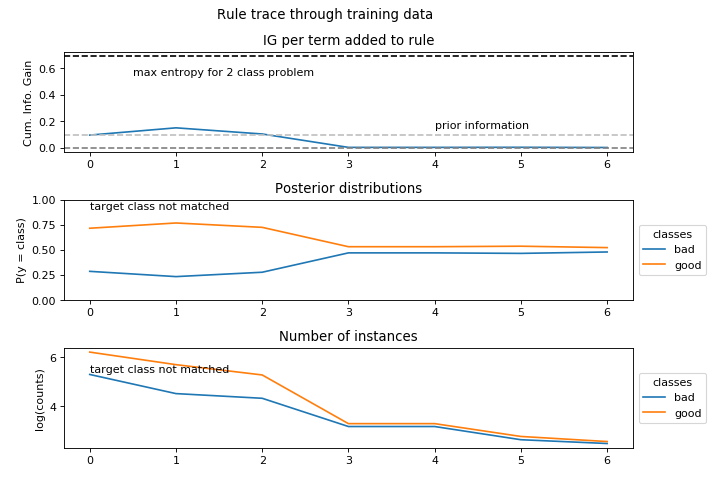

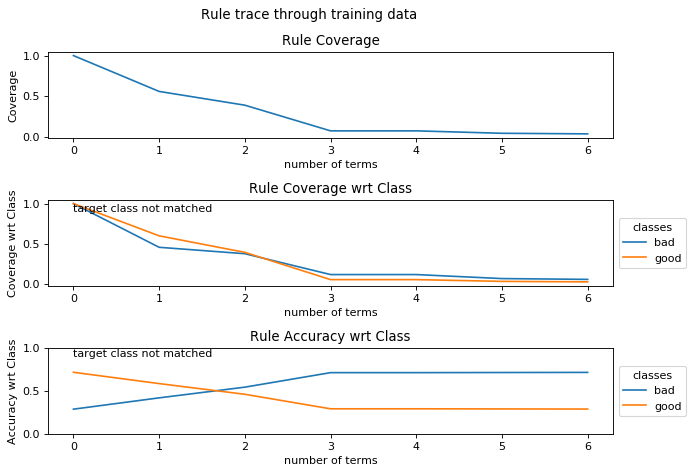

In [36]:
%run rf_analysis_utils.py
instance = 1
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='majority'), vars_dict, 2),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='minority'), vars_dict, 2),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

In [35]:
pretty_print(ra.rule, onehot_dict)
#[(f, t) for (f, t, _) in ra_min.rule].index(('amt', True))


['amt <= 2373.2',
 'chk_A11 True',
 'job_A173 True',
 'chk_A14 False',
 'dur > 10.26',
 'age <= 31.46',
 'chk_A11 True',
 'crhis_A34 False']

In [27]:
ra.prune_rule()
ra.pruned_rule

[('chk_A11', False, 0.5),
 ('crhis_A34', True, 0.5),
 ('job_A173', False, 0.5),
 ('pps_A41', True, 0.5),
 ('hous_A151', False, 0.5),
 ('crhis_A31', True, 0.5),
 ('pps_A40', True, 0.5),
 ('plans_A143', True, 0.5)]

In [28]:
ra.tight_rule

[('chk_A11', False, 0.5), ('job_A173', False, 0.5), ('hous_A151', False, 0.5)]

In [29]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([2], dtype=int64),
 'labels': array([0], dtype=int64),
 'p_counts': array([1.])}

In [23]:
p_count(training_labels.loc[apply_rule(ra.tight_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([18,  8], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.69230769, 0.30769231])}